In [1]:
import sys
import os

# Add project root to sys.path
project_root = os.path.abspath("..")  # one level up
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [2]:
import torch
from dev.slicing import slicing
from dev.test_functions import Gauss, Laplace, logarithmic, Riesz, thin_plate
from dev.constants import SQRT_2, DEVICE
from simple_torch_NFFT import Fastsum
from tqdm import tqdm
import matplotlib.pyplot as plt

torch.manual_seed(42)

In [3]:

def exact_mmd(F, scale, X, Y, Xw):
    k_mat = F(torch.norm(X[None, :, :]-Y[:, None, :], dim=2) / scale)
    return k_mat @ Xw


def relative_L1_error(X, Y):
    return torch.sum(torch.abs(X-Y)) / torch.sum(torch.abs(Y))


def build_kernel_params(F, d, method, mode, T, L, K, J, tau):
    def fourier_fun(x, scale):
        x_pos = torch.abs(x)
        S = slicing(F=lambda t: F(t/(2*scale*T)), d=d,
                    method=method, mode=mode, T=T, L=L, K=K, J=J, tau=tau)
        S.get_matrix()
        S.get_range_coef()
        S.get_domain_coef()
        a = S.a / 2
        a[0] *= SQRT_2
        a = torch.cat([a, torch.tensor([0.0], device=DEVICE)])
        f_hat = a[x_pos]
        return f_hat
    return dict(fourier_fun=fourier_fun)



In [4]:
d = 1000
T, L, K, J, tau = 1, 2**10, 2**8, 2**8, 1e-6
N, M, P = 100, 100, 1000
slicing_mode = "orthogonal"


Functions = [Gauss, Laplace, logarithmic, Riesz, thin_plate]
Function_names = ["Gauss", "Laplace", "logarithmic", "energy", "thin_plate"]
reps = 10

X = torch.randn((N, d, reps), device=DEVICE)
Y = torch.randn((M, d, reps), device=DEVICE)
Xw = torch.rand((N, reps), device=DEVICE)
scale = torch.median(torch.norm(X, dim=1)).item()


L1_ers = torch.zeros(len(Functions), reps, 3)
for F_idx in tqdm(range(len(Functions))):
    for rep in range(reps):
        kernel_sum = exact_mmd(
            Functions[F_idx], scale, X[:, :, rep], Y[:, :, rep], Xw[:, rep])

        kernel_params = build_kernel_params(
            Functions[F_idx], d, 1, 2, T, L, K, J, tau)
        fastsum1 = Fastsum(d, kernel="other", device=DEVICE,
                           kernel_params=kernel_params,
                           n_ft=2*K,
                           slicing_mode=slicing_mode)
        kernel_sum1 = fastsum1(X[:, :, rep], Y[:, :, rep],
                               Xw[:, rep], scale, P)

        kernel_params = build_kernel_params(
            Functions[F_idx], d, 2, 2, T, L, K, J, tau)
        fastsum2 = Fastsum(d, kernel="other", device=DEVICE,
                           kernel_params=kernel_params,
                           n_ft=2*K,
                           slicing_mode=slicing_mode)
        kernel_sum2 = fastsum1(X[:, :, rep], Y[:, :, rep],
                               Xw[:, rep], scale, P)

        fastsum0 = Fastsum(d, kernel=Function_names[F_idx], device=DEVICE,
                           n_ft=2*K,
                           slicing_mode=slicing_mode)
        kernel_sum0 = fastsum2(X[:, :, rep], Y[:, :, rep],
                               Xw[:, rep], scale, P)

        L1_ers[F_idx, rep, 0] = relative_L1_error(kernel_sum0, kernel_sum)
        L1_ers[F_idx, rep, 1] = relative_L1_error(kernel_sum1, kernel_sum)
        L1_ers[F_idx, rep, 2] = relative_L1_error(kernel_sum2, kernel_sum)


# Compute means and std dev along axis=1 (the M dimension)
means = torch.mean(L1_ers, dim=1)          # shape (N, 2)
std_devs = torch.std(L1_ers, dim=1)        # shape (N, 2)

  0%|                                                     | 0/5 [00:00<?, ?it/s]/homes/numerik/rux/store/miniconda3/envs/torch_gpu/lib/python3.9/site-packages/torch/_inductor/lowering.py:1713: UserWarning: Torchinductor does not support code generation for complex operators. Performance may be worse than eager.
  warnings.warn(
100%|█████████████████████████████████████████████| 5/5 [00:28<00:00,  5.71s/it]


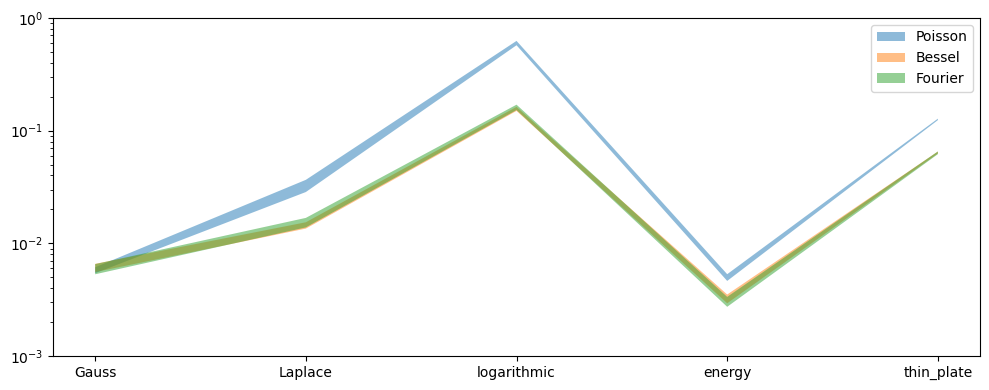

In [5]:
# x-axis indices
x_ax = torch.arange(len(Functions))
plt.figure(figsize=(10, 4))  # Wider figure: 10 inches wide, 4 inches tall
# Plot both methods
#plt.plot(x_ax, means[:, 0].cpu(), label='Method 1 Mean')
plt.fill_between(x_ax, (means[:, 0] - std_devs[:, 0]).cpu(),
                 (means[:, 0] + std_devs[:, 0]).cpu(), alpha=0.5, label='Poisson')

#plt.plot(x_ax, means[:, 1].cpu(), label='Method 2 Mean')
plt.fill_between(x_ax, (means[:, 1] - std_devs[:, 1]).cpu(),
                 (means[:, 1] + std_devs[:, 1]).cpu(), alpha=0.5, label='Bessel')

plt.fill_between(x_ax, (means[:, 2] - std_devs[:, 2]).cpu(),
                 (means[:, 2] + std_devs[:, 2]).cpu(), alpha=0.5, label='Fourier')

plt.yscale('log')
plt.ylim([1e-3, 1e+0])
plt.xticks(ticks=torch.arange(len(Functions)), labels=Function_names)
plt.legend()
plt.tight_layout()
plt.savefig(f"poisson_d={d}.pdf")
plt.show()